# Generate RAW file with simultaneous drifting signals
This notebook generates a RAW file with multiple drifting signals using setigen.  These can be used for end-to-end testing of DeDoppler detection performance.  

Note: only a single array element (or beam) is generated for use in seticore dedoppler mode or in turbo seti. Raw files with GBT, MeerKat or COSMIC parameters may be generated.

After generating the raw file, rawspec is run and spectra are created for verification.

To run successfully, one needs to set up RAWDIR, SGDIR and SETIGEN_PATH in the shell, 
e.g "export RAWDIR=$HOME/data_files/raw_files" in .profile

Per setigen instructions (B Bryski): If you have access to a GPU, it is highly recommended to install CuPy, which performs the equivalent NumPy array operations on the GPU (https://docs.cupy.dev/en/stable/install.html). This is not necessary to run raw voltage generation, but will highly accelerate the pipeline. Once you have CuPy installed, to enable GPU acceleration you must set `SETIGEN_ENABLE_GPU` to '1' in the shell or in Python via `os.environ`. It can also be useful to set `CUDA_VISIBLE_DEVICES` to specify which GPUs to use.

One raw file is generated and placed in $RAWDIR for each execution.  If a raw file with the same name already exists, an error is generated to prevent accidental overwriting of files that may take hours to produce.  Simply delete the file in $RAWDIR or adjust parameters so there is no file name conflict.  File names indicate 1) the telescope, 2) number of drifting tones, 3) signal amplitude, 4) min/max of the drifting tone frequencies, 5) min/max of drift rates, and 6) total duration in seconds.

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os

%matplotlib inline
import matplotlib.pyplot as plt
params = {'legend.fontsize': 'medium',
          'figure.figsize': (10,6),
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
plt.rcParams.update(params)

import numpy as np
from astropy import units as u
import blimpy as bl
import time
import pandas

from pathlib import Path

sys.path.append(os.getenv('SETIGEN_PATH'))

import setigen as stg

raw_dir = os.getenv('RAWDIR') + '/'
if not os.path.isdir(raw_dir[0:-1]):
    os.system('mkdir '+raw_dir[0:-1])

sg_dir = os.getenv('SGDIR') + '/'
if not os.path.isdir(sg_dir[0:-1]):
    os.system('mkdir '+sg_dir[0:-1])

def db(x):
    """ Convert linear value to dB value """
    return 10*np.log10(np.abs(x.astype(np.float64))+1e-20)


In [2]:
os.environ['SETIGEN_ENABLE_GPU'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
# Sometimes it can be necessary to re-run this command for plots to show automatically
%matplotlib inline

### Parameter setup
Comment or uncomment for the desired parameter combinations

In [4]:

#signal_level = .001
#signal_level = .002
signal_level = .004
# signal_level = .010
# signal_level = 0.

display_figs = True
plot_spectra = True
plot_snr_vs_f = True
fig_dir = sg_dir

verbose = True

drift_limit_nHz = 1.0  # assume 2 sigma limit
f_sigma_drift = np.array([1.5, 3, 6])*1e9
sigma_drift = drift_limit_nHz*f_sigma_drift/2.*1e-9
print(f'sigma_drift = {sigma_drift}')

n_bits = 8
bytes_per_sample = 2*(n_bits/8)  # each sample has 8-bit I and 8-bit Q

if (1):
    sig_max_drift = 10
    sig_min_drift = -10
    n_chirp = 80
else:
    sig_max_drift = 0
    sig_min_drift = 0
    n_chirp = 41

if (1):  # GBT/Parkes HSR2A, but 512 avg rather than 51*16=816 avg (183 sec vs 292)
    subsample_factor = 128
    sample_rate = 3e9 // subsample_factor
    num_taps = 8
    num_branches = 1024 // subsample_factor

    coarse_fft_size = num_branches
    # num_blocks = 128     # 366 sec, 16 GB
    # num_blocks = 64     # 183.25 sec, 8 GB
    # num_blocks = 32     # 91. sec, 4 GB
    # num_blocks = 16     # 43.82 sec, 2 GB
    # num_blocks = 8      # 22.90 sec, 1 GB
    num_blocks = 2      # 5.72 sec, 257 MB test case
    block_size = 2**27  # 32*1024*1024 bytes, 16M real samples*2 pol
    num_pols = 2

    fine_fft_size = 1024*1024
    if (num_blocks>=8):
        n_sti = 4
    else:
        n_sti = 1
    
    fch1_MHz = 6000
    f_start1_MHz = 6002.2
    f_stop1_MHz = 6003.8

    stem_name = 'gbt-chirp'
    telescope_name = 'GBT'

elif (0):   # MeerKAT 1K mode, single antenna or beam
    subsample_factor = 128
    sample_rate = 1.71e9 // subsample_factor
    num_taps = 8
    num_branches = 2048 // subsample_factor

    coarse_fft_size = num_branches
    #num_blocks = 64     # 321 sec, 8 GB
    #num_blocks = 32     # 160 sec, 4 GB
    num_blocks = 16     # 80 sec, 2 GB
    block_size = 2**27
    num_pols = 2

    fine_fft_size = 512*1024
    n_sti = 8

    fch1_MHz = 1500
    f_start1_MHz = 1502.3
    f_stop1_MHz = 1502.7
    
    stem_name = 'meerkat-chirp'
    telescope_name = 'MEERKAT'

elif (1):  # COSMIC standard observation, single antenna or beam
    subsample_factor = 128
    sample_rate = 2.048e9 // subsample_factor
    num_taps = 8
    num_branches = 2048 // subsample_factor

    coarse_fft_size = num_branches
    num_blocks = 16
    block_size = 2**27
    num_pols = 2

    if (1):
        sig_max_drift = 10
        sig_min_drift = -10
        n_chirp = 80
    elif (1):
        sig_max_drift = 50
        sig_min_drift = -50
        n_chirp = 80

    fine_fft_size = 512*1024
    n_sti = 1

    fch1_MHz = 1400
    f_start1_MHz = 1401.7
    f_stop1_MHz = 1402.3
    
    stem_name = 'cosmic-chirp'
    telescope_name = 'VLA'    # not in guppi list

elif (1):  # COSMIC VLASS, single antenna or beam
    subsample_factor = 128
    sample_rate = 2.1475e9 // subsample_factor
    num_taps = 8
    num_branches = 2048 // subsample_factor

    coarse_fft_size = num_branches
    num_blocks = 2
    block_size = 2**27
    num_pols = 2

    fine_fft_size = 128*1024
    n_sti = 1

    fch1_MHz = 1400
    f_start1_MHz = 1401.8
    f_stop1_MHz = 1402.4
    
    stem_name = 'vlass-chirp'
    telescope_name = 'VLA'    # not in guppi list


sigma_drift = [0.75 1.5  3.  ]


In [5]:

# f_jitter = 2*(rng.random(n_chirp)-0.5)
f_start_truth = np.linspace(f_start1_MHz*1e6,f_stop1_MHz*1e6,n_chirp)
drift_rate_truth = np.linspace(sig_min_drift,sig_max_drift,n_chirp)
f_start_incr = f_start_truth[1]-f_start_truth[0]
df_dt_incr = drift_rate_truth[1]-drift_rate_truth[0]

n_coarse_channels = num_branches/2
t_coarse = num_branches/sample_rate
t_fine = t_coarse * fine_fft_size
t_res = t_fine * n_sti
n_coarse_samples = num_blocks*block_size/num_pols/n_coarse_channels/bytes_per_sample
n_fine_samples = n_coarse_samples/fine_fft_size
n_lti = n_fine_samples/n_sti
t_obs = n_fine_samples*t_fine
bw_coarse = 1./t_coarse
bw_fine = 1./t_fine
print(f'{t_coarse = :.3e} {t_fine = :.3f} {t_res = :.3f} {t_obs = :4.2f} sec')
print(f'{n_coarse_samples = :.0f} {n_fine_samples = :.0f} {n_sti = :.0f} {n_lti = :.0f} samples')
print(f'{bw_coarse = :.3f} {bw_fine = :.3f} Hz')

snr_input_db = 10*np.log10(signal_level**2 /2/2)  # 1/2 real->complex,1/2 2 pols
snr_coarse_db = snr_input_db + 10*np.log10(n_coarse_channels)
snr_fine_db = snr_coarse_db + 10*np.log10(fine_fft_size)
snr_det_db = snr_fine_db + 5*np.log10(n_sti*n_lti)

print('signal_level={0:6.4f}, Input SNR={1:4.2f} Coarse SNR={2:4.2f} Fine SNR={3:4.2f} Det SNR={4:4.2f} dB'.format(\
        signal_level,snr_input_db,snr_coarse_db,snr_fine_db,snr_det_db))

ref_snr_db = snr_det_db
print('signal_level={0:6.4f}, Est SNR={1:4.2f}, Reference SNR={2:4.2f} dB'.format(signal_level,snr_det_db,ref_snr_db))

if verbose:
    np.set_printoptions(precision=2)
    print('f_start_truth = ',f_start_truth*1e-6,' MHz')
    print('drift_rate_truth = ',drift_rate_truth,' Hz/sec')

sig_min_drift_str = f'{sig_min_drift:.1f}'
sig_max_drift_str = f'{sig_max_drift:.1f}'
# replace minus sign with 'm' for negative drift limits in raw file name
if (sig_min_drift<0): sig_min_drift_str = 'm' + sig_min_drift_str[1:]
if (sig_max_drift<0): sig_max_drift_str = 'm' + sig_max_drift_str[1:]
raw_file_stem = '%s%d-%.4fV-%.2f-%.2f-%s-%s-Hzsec-%.2fsec'%(stem_name,n_chirp, \
            signal_level,f_start1_MHz,f_stop1_MHz,sig_min_drift_str,sig_max_drift_str,t_obs)
if verbose: print(raw_file_stem)

# open directory for figures if necessary
if not os.path.isdir(fig_dir[0:-1]):
    os.system('mkdir '+fig_dir[0:-1])
# empty old figures

config_str = 'Fine FFT Size=%.0fK, Nsti=%d'%(fine_fft_size/1024,n_sti)
config_str2 = 'FineFFT-%.0fK-Nsti-%02d'%(fine_fft_size/1024,n_sti)
if verbose:print(config_str,'\n',config_str2)
fig_name_base = raw_file_stem + '-' + config_str2
if verbose: print(f'{fig_name_base = }')

fig_df = (np.amax(f_start_truth)*1e-6 - np.amin(f_start_truth)*1e-6)*.25
fig_f_limits_MHz = [np.amin(f_start_truth)*1e-6 - fig_df,np.amax(f_start_truth)*1e-6 + fig_df]
if verbose: 
    print("figure freq limits MHz: ",fig_f_limits_MHz)


t_coarse = 3.413e-07 t_fine = 0.358 t_res = 0.358 t_obs = 5.73 sec
n_coarse_samples = 16777216 n_fine_samples = 16 n_sti = 1 n_lti = 16 samples
bw_coarse = 2929687.500 bw_fine = 2.794 Hz
signal_level=0.0040, Input SNR=-53.98 Coarse SNR=-47.96 Fine SNR=12.25 Det SNR=18.27 dB
signal_level=0.0040, Est SNR=18.27, Reference SNR=18.27 dB
f_start_truth =  [6002.2  6002.22 6002.24 6002.26 6002.28 6002.3  6002.32 6002.34 6002.36
 6002.38 6002.4  6002.42 6002.44 6002.46 6002.48 6002.5  6002.52 6002.54
 6002.56 6002.58 6002.61 6002.63 6002.65 6002.67 6002.69 6002.71 6002.73
 6002.75 6002.77 6002.79 6002.81 6002.83 6002.85 6002.87 6002.89 6002.91
 6002.93 6002.95 6002.97 6002.99 6003.01 6003.03 6003.05 6003.07 6003.09
 6003.11 6003.13 6003.15 6003.17 6003.19 6003.21 6003.23 6003.25 6003.27
 6003.29 6003.31 6003.33 6003.35 6003.37 6003.39 6003.42 6003.44 6003.46
 6003.48 6003.5  6003.52 6003.54 6003.56 6003.58 6003.6  6003.62 6003.64
 6003.66 6003.68 6003.7  6003.72 6003.74 6003.76 6003.78 6003.8 ]

#### Generate error and exit if output raw file already exists

In [6]:
raw_file_base_name = raw_dir + raw_file_stem + '.0000.raw'
compute_raw = not os.path.isfile(raw_file_base_name)
if not compute_raw: 
    print(f'Destination Base Raw File: {raw_file_base_name}')
    raise FileExistsError('Destination file exists, nothing generated, delete before creating new file')

#### Generate .raw file using setigen

In [7]:
target_fwhm = 32
# target_fwhm = 8

digitizer = stg.voltage.RealQuantizer(target_fwhm=target_fwhm,
                                           num_bits=8)

filterbank = stg.voltage.PolyphaseFilterbank(num_taps=num_taps, 
                                            num_branches=num_branches)

requantizer = stg.voltage.ComplexQuantizer(target_fwhm=target_fwhm,
                                        num_bits=8)

antenna = stg.voltage.Antenna(sample_rate=sample_rate, 
                            fch1=fch1_MHz*u.MHz,
                            ascending=True,
                            num_pols=2)


rvb = stg.voltage.RawVoltageBackend(antenna,
                                    digitizer=digitizer,
                                    filterbank=filterbank,
                                    requantizer=requantizer,
                                    start_chan=0,
                                    num_chans=num_branches//2,
                                    block_size=block_size,
                                    blocks_per_file=128,
                                    num_subblocks=32)
if compute_raw:
    # Add noise
    for stream in antenna.streams:
        stream.add_noise(v_mean=0, v_std=1)
        
    # Add signals

    for idx, f_start in enumerate(f_start_truth):
        drift_rate = drift_rate_truth[idx]
        #leakage_factor = stg.voltage.get_leakage_factor(f_start, rvb, coarse_fft_size)
        for stream in antenna.streams:
            level = stream.get_total_noise_std() * signal_level
            stream.add_constant_signal(f_start=f_start, 
                                    drift_rate=drift_rate*u.Hz/u.s, 
                                    level=level)
            
    t_compute_raw_start = time.time()
    rvb.record(output_file_stem=raw_dir + raw_file_stem,
            num_blocks=num_blocks, 
            length_mode='num_blocks',
            header_dict={'HELLO': 'test_value',
                            'TELESCOP': telescope_name},
            verbose=False)
        
    t_compute_raw = time.time() - t_compute_raw_start
else:
    t_compute_raw = 0

print(f"{t_compute_raw = :.2f} sec")


Blocks: 100%|██████████| 2/2 [08:05<00:00, 242.98s/it]

t_compute_raw = 485.97 sec


In [8]:
raw_params = stg.voltage.get_raw_params(input_file_stem=raw_dir + raw_file_stem,
                                        start_chan=0)
if verbose: print(raw_params)

{'num_bits': 8, 'chan_bw': 2929687.5, 'ascending': True, 'num_pols': 2, 'block_size': 134217728, 'obs_length': 5.726623061333333, 'tbin': 3.41333333333333e-07, 'num_antennas': 1, 'num_chans': 4, 'center_freq': 6004394531.25, 'fch1': 6000000000.0}


In [9]:
import src.get_raw_info as raw
p = raw.get_run_params(raw_file_stem,raw_dir,fine_fft_size,n_sti)
print(p)


raw_file_name='/home/kmh4005/data_files/raw_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-5.73sec.0000.raw' found, n_blocks_incr=2, n_blocks=2
raw_file_name='/home/kmh4005/data_files/raw_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-5.73sec.0001.raw' not found, n_raw_files=1, Total blocks=2
raw_file_base_name = '/home/kmh4005/data_files/raw_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-5.73sec.0000.raw'
Raw file found
Raw File size =    256 MB, n_raw_files = 1
expected_file_size = 256.0 MB excl header

GBT     , Tue Sep 22 00:24:27 2020, mjd_day=59114, TMC1    , ra_deg = 70.441, dec_deg = 25.691
ctr_freq_MHz = 6004.395, obs_bw_MHz = 11.71875, f_min_MHz = 5998.535, f_max_MHz = 6010.254

t_obs = 5.727, n_antennas = 1, n_coarse_channels = 4, n_pols = 2, n_bits = 8, chan_bw = 2929687.500
fs_coarse = 2929687.500, fine_fft_size = 1048576, n_sti = 1, n_lti = 16.0, n_avg = 16.0
t_coarse = 3.413e-07, t_fine = 0.358, t_res = 0.358
fs_coarse = 2929687.500, f

#### Generate filterbank file using rawspec for verification

In [10]:
fb_ext = '.h5'
raw_call_string = 'rawspec -f %d -t %d -j '%(fine_fft_size,n_sti) + raw_dir + raw_file_stem
if verbose: print(raw_call_string + '\n')
t1 = time.time()
os.system(raw_call_string)
t_rawspec = time.time() - t1
print('\nRawspec %.2f sec'%t_rawspec)

file_stats = os.stat(raw_file_base_name)
raw_size_MB = file_stats.st_size/1024/1024
if verbose: print(f'raw File size = {raw_size_MB:6.0f} MB')


rawspec -f 1048576 -t 1 -j /home/kmh4005/data_files/raw_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-5.73sec

rawspec 3.1.1+12@gaf37c70-dirty using librawspec 3.1.1+12@gaf37c70-dirty and cuFFT 11.0.12.1
writing output files in FBH5 format
working stem: /home/kmh4005/data_files/raw_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-5.73sec
opening file: /home/kmh4005/data_files/raw_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-5.73sec.0000.raw
Number of spectra per dump (Nd) = 8
Number of fine channels per coarse channel (nfpc) = 1048576
Chunk dimensions = (8, 1, 1048576)
Cache nslots = 8388609, nbytes = 134217729
opening file: /home/kmh4005/data_files/raw_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-5.73sec.0001.raw [No such file or directory]
output product 0: 16 spectra

Rawspec 1.25 sec
raw File size =    256 MB


#### Augment file name of filterbank h5/fil file to include parameters (fft, n_sti) and move to $SGDIR

In [11]:
import glob
import os
h5_name_list = glob.glob(raw_dir + raw_file_stem + '.*' + fb_ext)
print(raw_dir + raw_file_stem + '.*' + fb_ext)
print(h5_name_list,'\n')

for i_name, h5_name in enumerate(h5_name_list):
    h5_parts = h5_name.split('.rawspec')
    print(f'{h5_parts = }')
    new_h5_name = h5_parts[0] + '-fft%.0fK-int%02d'%(fine_fft_size/1024,n_sti) + '.rawspec' + h5_parts[1]
    if (1):   # change output directory from raw_dir to sg_dir
        new_h5_name = sg_dir + os.path.basename(new_h5_name)
    if (i_name==0):
        base_h5_name = new_h5_name
    if verbose: print(f'{new_h5_name = }')
    os.system('mv ' + h5_name + ' ' + new_h5_name)

if verbose:
    print(f'{base_h5_name = }')

file_stats = os.stat(new_h5_name)
h5_size_MB = file_stats.st_size/1024/1024
print(f'H5 File size = {h5_size_MB:6.0f} MB')


/home/kmh4005/data_files/raw_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-5.73sec.*.h5
['/home/kmh4005/data_files/raw_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-5.73sec.rawspec.0000.h5'] 

h5_parts = ['/home/kmh4005/data_files/raw_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-5.73sec', '.0000.h5']
new_h5_name = '/home/kmh4005/data_files/sg_det_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-5.73sec-fft1024K-int01.rawspec.0000.h5'
base_h5_name = '/home/kmh4005/data_files/sg_det_files/gbt-chirp80-0.0040V-6002.20-6003.80-m10.0-10.0-Hzsec-5.73sec-fft1024K-int01.rawspec.0000.h5'
H5 File size =    219 MB


#### Plot spectrogram over frequency of interest

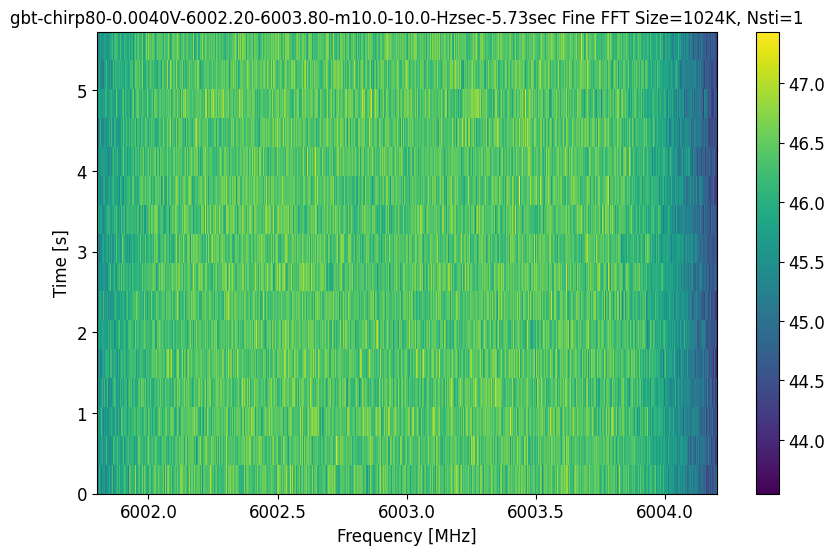

In [13]:
if plot_spectra:
        import src.plot_h5_psd_sg1 as plts

        %matplotlib inline

        plts.plot_h5_sg1(base_h5_name,
                fig_f_limits_MHz=fig_f_limits_MHz,
                min_max_db=[],
                fig_title=raw_file_stem  + ' ' + config_str,
                display_fig=display_figs,
                savfig_name=fig_dir+'01-'+fig_name_base+'-waterfall.png')
        

#### Plot averaged PSD over frequency of interest

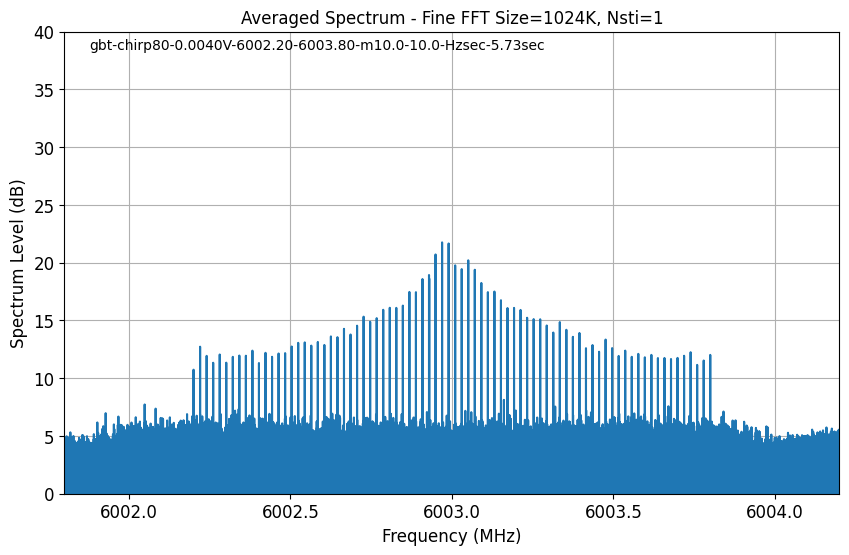

In [14]:
if plot_snr_vs_f:
        import src.plot_h5_psd_sg1 as plts

        %matplotlib inline

        plts.plot_h5_psd1(base_h5_name,
                fig_f_limits_MHz=fig_f_limits_MHz,
                min_max_db=[0.,np.amax((40.,ref_snr_db))],
                fig_title='Averaged Spectrum - '+config_str,
                fig_text_list=[[.15,.85,raw_file_stem]],
                display_fig=display_figs,
                savfig_name=fig_dir+'02-'+fig_name_base+'-psd.png')


averaging along time axis...


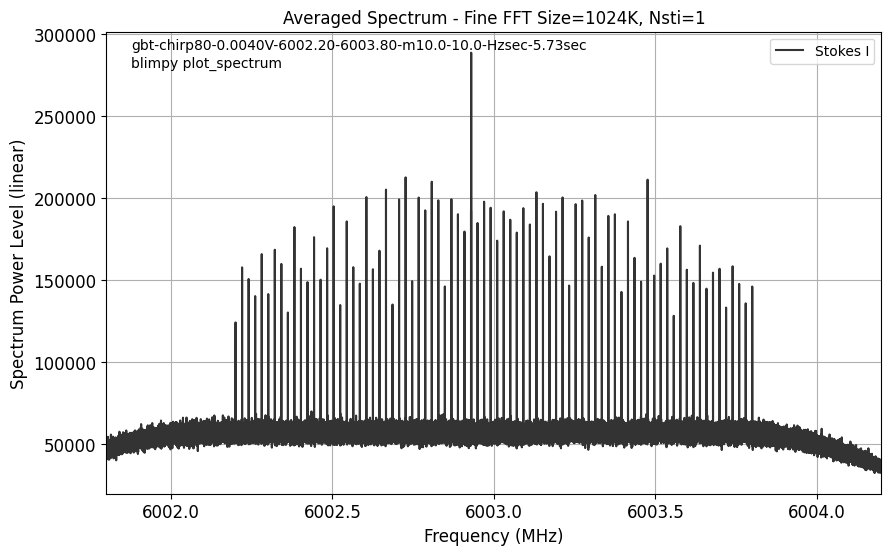

In [15]:
if plot_snr_vs_f:
        import src.plot_h5_psd_sg1 as plts

        %matplotlib inline

        plts.plot_h5_psd2(base_h5_name,
                fig_f_limits_MHz=fig_f_limits_MHz,
                #min_max=[1e6,7e6],
                fig_title='Averaged Spectrum - '+config_str,
                fig_text_list=[[.15,.85,raw_file_stem],[.15,.82,'blimpy plot_spectrum']],
                display_fig=display_figs,
                savfig_name=fig_dir+'03-'+fig_name_base+'-psd.png')


In [16]:
# print(h5_name)
# os.system('rm '+new_h5_name)
